In [85]:
import os
import numpy as np
import torch
import tqdm
import copy
import time
import cv2 as cv
import matplotlib.pyplot as plt


from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw
#from IPython import display
#from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torchvision

import torch.nn as nn
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from utility import *

## Training Pnet Notebook

Again the MTCNN is composed of 3 networks, Pnet, Rnet and Onet, on this notebook and part of the project we focus mainly on the Pnet. The idea is that we try all the combinations to see how good we can get while modifying only the Pnet, and if there is an optimal way to train, so that we can later use it to train Rnet and Onet.

### Helper methods

The following methods are designed to allow for a full training and testing of the Pnet network. Most of them don't need to be modified, except :
- get_transformation(input_size) : To change if you want to apply different transformation/data augmentation input size etc ...
- the "Modify network" cell : To modify if you want to freeze/unfreeze layers

In [86]:
def get_transformation(input_size) :
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),
            transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }
    
    return data_transforms

In [87]:
def print_set_exemple(dataloaders_dict) :
    
    dataiter = iter(dataloaders_dict["train"])
    images_display, labels_display = dataiter.next()

    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    imshow(torchvision.utils.make_grid(images_display))
    print(labels_display)

In [88]:
def parameters_to_update(model) : 
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.

    params_to_update = model.parameters()
    names = []
    print("Params to learn:")
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            names.append(name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=lambda_, momentum=0.9)
    return optimizer_ft, names

In [89]:
def print_histogram(num_epochs, hist_train, hist_val, folder_store, name) :
    
    plt.plot(range(num_epochs), hist_train, color = "blue", label = "train error")
    plt.plot(range(num_epochs), hist_val, color='orange', label = "val error")
    plt.title("History of the train/val losses")
    plt.legend()
    plt.savefig("mtcnn_models/%s/hist%s.png"%(folder_store, name))
    plt.show()

In [90]:
def train_model(model, dataloaders, criterion, optimizer, network, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_err_history = []
    train_err_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if network == "onet" :
                        outputs_box, output_landmark, aux_outputs = model(inputs)
                        
                    else :
                        outputs, aux_outputs = model(inputs)

                    aux_outputs = aux_outputs.reshape(-1, num_classes)
                    loss = criterion(aux_outputs, labels)
                    _, preds = torch.max(aux_outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_err_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_err_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_err_history, train_err_history

In [91]:
def pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = 70, num_classes = 2, batch_size = 32, lambda_ = 0.001) :
    data_transforms = get_transformation(input_size)
    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print("Printing training images : ")
    print_set_exemple(dataloaders_dict)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.

    optimizer_ft, name_layer = parameters_to_update(model)
    
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    
    print("Starting the training : ")
    # Train and evaluate
    model_ft, hist_val, hist_train = train_model(model, dataloaders_dict, criterion, optimizer_ft, network, num_epochs=num_epochs)
    
    # Save the model 
    print("Saving the model : ")
    ensure_dir("mtcnn_models/%s/%s-%s.pth"%(folder_store, model_name, network))
    torch.save(mtcnn.state_dict(), "mtcnn_models/%s/%s-%s.pth"%(folder_store, model_name, network))
    
    
    print_histogram(num_epochs, hist_train, hist_val, folder_store, network)
    
    print("Saving the hyperparameters : ")
    f = open("mtcnn_models/%s/params%s.txt"%(folder_store, network), "w")
    f.write("Dataset : %s"%(data_dir) + '\n')
    f.write("Num epochs : %s"%(num_epochs) + '\n')
    f.write("lambda : %s"%(lambda_) + '\n')
    f.write("Transforms for %s: %s"%(network, data_transforms) + '\n')
    f.write("Layers for %s: %s"%(network, name_layer) + '\n')
    f.close()

In [92]:
from matplotlib import pyplot as plt

def print_exemple(index, images, pred_mtcnn, groundtruth, display = True) :
    copy = images[index].copy()
    
    if pred_mtcnn[index] is not None:
        for (column, row, width, height) in pred_mtcnn[index]:
            cv.rectangle(copy, (column, row), (width, height),
            (0, 255, 0), 2 )
        
        
    if groundtruth[index].size > 0 :
        for (x1, y1, x2, y2) in groundtruth[index][:, 1:]:
            cv.rectangle(copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
    copy = resize_img(copy, width=680)
    if display :
        cv.imshow("example", copy)
        cv.waitKey(0)  
        cv.destroyAllWindows()  
    return copy

In [93]:
def testing(folder_test, folder_store, network, display = False, img_skip = [], get_fp = False) :
    # We load the images and groundtruth, the resize them (so the the prediction time is lower)
    
    if get_fp :
        folder_img="%s/img_train"%(folder_test)
        folder_gt="%s/gt_train"%(folder_test)
    else :
        folder_img="%s/img_test"%(folder_test)
        folder_gt="%s/gt_test"%(folder_test)
    
    images, path_img = load_images_from_folder(folder_img)
    groundtruth, path_gt = load_face_groundtruth_from_folder(folder_gt, 5)
    resize_img_and_gt(800, images, groundtruth)
    
    for skip in img_skip :
        del images[skip]
        del groundtruth[skip]

    # Convert for MTCNN
    img_mtcnn = [Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)) for frame in images]

    # Detect faces
    pred_mtcnn = []
    for img in tqdm.tqdm(img_mtcnn) :
        detected_faces, _ = mtcnn.detect(img)
        pred_mtcnn.append(detected_faces)
        
    for i in range(len(images)):
        r = print_exemple(i, images, pred_mtcnn, groundtruth, display = False)
        ensure_dir("mtcnn_models/%s/sample_test/%s/%s.jpg"%(folder_store, network, f"{i:04}"))
        result = cv.imwrite("mtcnn_models/%s/sample_test/%s/%s.jpg"%(folder_store, network, f"{i:04}"), r)
        
    tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
    precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
    print(precision, recall, f_score)


    f = open("mtcnn_models/%s/params%s.txt"%(folder_store, network), "a")
    f.write("Results from %s : Precision : %s, Recall : %s, F_score : %s"%(folder_test, precision, recall, f_score) + '\n')

    f.close()
    
    return pred_mtcnn, groundtruth

In [94]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
data_dir = "../dataset/faces/style2/v1"

# Model name to save the parameters
model_name = "full_training_s2_v2"
folder_store = "full_training_s2_v2"

# Number of classes in the dataset (Here only faces/not faces)
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 110

# Learning Rate D
lambda_ = 0.001

In [95]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

Running on device: cuda:0


In [96]:
## To load a model :
#mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_s1_v0/full_training_s1_v0-onet.pth", map_location=device))

#### Modify network 

In [97]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.pnet
network = "pnet"
input_size = 12

#Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False

# model.conv2.weight.requires_grad = False
# model.conv2.bias.requires_grad = False
# model.prelu2.weight.requires_grad = False

# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False

model.conv4_2.weight.requires_grad = False
model.conv4_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

Initializing Datasets and Dataloaders...
Printing training images : 


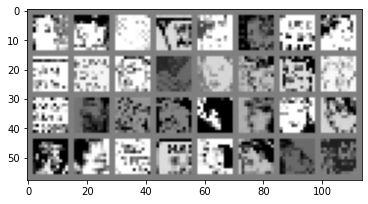

tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1])
Params to learn:
	 conv2.weight
	 conv2.bias
	 prelu2.weight
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4_1.weight
	 conv4_1.bias
Starting the training : 
Epoch 0/109
----------
train Loss: 0.6621 Acc: 0.6142
val Loss: 0.6311 Acc: 0.6477
Epoch 1/109
----------
train Loss: 0.6107 Acc: 0.6747
val Loss: 0.5863 Acc: 0.6993
Epoch 2/109
----------
train Loss: 0.5973 Acc: 0.6934
val Loss: 0.5558 Acc: 0.7402
Epoch 3/109
----------
train Loss: 0.5765 Acc: 0.7174
val Loss: 0.5384 Acc: 0.7651
Epoch 4/109
----------
train Loss: 0.5665 Acc: 0.7290
val Loss: 0.5366 Acc: 0.7580
Epoch 5/109
----------
train Loss: 0.5599 Acc: 0.7445
val Loss: 0.5322 Acc: 0.7580
Epoch 6/109
----------
train Loss: 0.5598 Acc: 0.7343
val Loss: 0.5230 Acc: 0.7705
Epoch 7/109
----------
train Loss: 0.5524 Acc: 0.7445
val Loss: 0.5179 Acc: 0.7883
Epoch 8/109
----------
train Loss: 0.5463 Acc: 0.7508
val Los

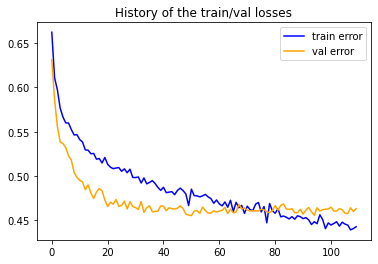

Saving the hyperparameters : 


In [98]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

In [15]:
folder_test = "../dataset/train_test/good"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/average"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/bad"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/complete"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

Testing on the ../dataset/train_test/good folder : 
 Precision, Recall, f-score


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


0.8493150684931506 0.6158940397350994 0.7140115163147792
Testing on the ../dataset/train_test/average folder : 
 Precision, Recall, f-score


100%|██████████| 76/76 [00:36<00:00,  2.10it/s]


0.7244582043343654 0.4254545454545455 0.5360824742268042
Testing on the ../dataset/train_test/bad folder : 
 Precision, Recall, f-score


 65%|██████▌   | 36/55 [00:19<00:10,  1.81it/s]


IndexError: The shape of the mask [2917] at index 0 does not match the shape of the indexed tensor [2918, 4] at index 0

In [ ]:
# mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_compl_fp_v3/full_training_compl_fp_v3-pnet.pth", map_location=device))

### Train Rnet

In [99]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.rnet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False

model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False

# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False

# model.dense4.weight.requires_grad = False
# model.dense4.bias.requires_grad = False
# model.prelu4.weight.requires_grad = False

model.dense5_2.weight.requires_grad = False
model.dense5_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

network = "rnet"
input_size = 24
num_epochs = 110

Initializing Datasets and Dataloaders...
Printing training images : 


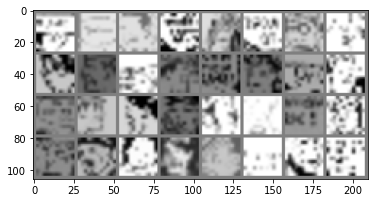

tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0])
Params to learn:
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 dense4.weight
	 dense4.bias
	 prelu4.weight
	 dense5_1.weight
	 dense5_1.bias
Starting the training : 
Epoch 0/109
----------
train Loss: 0.5899 Acc: 0.7143
val Loss: 0.5532 Acc: 0.7598
Epoch 1/109
----------
train Loss: 0.5402 Acc: 0.7650
val Loss: 0.5238 Acc: 0.7900
Epoch 2/109
----------
train Loss: 0.5298 Acc: 0.7730
val Loss: 0.5086 Acc: 0.7972
Epoch 3/109
----------
train Loss: 0.5150 Acc: 0.7988
val Loss: 0.5027 Acc: 0.8025
Epoch 4/109
----------
train Loss: 0.5073 Acc: 0.8028
val Loss: 0.4964 Acc: 0.8078
Epoch 5/109
----------
train Loss: 0.5028 Acc: 0.8020
val Loss: 0.4927 Acc: 0.8132
Epoch 6/109
----------
train Loss: 0.4996 Acc: 0.8144
val Loss: 0.4875 Acc: 0.8238
Epoch 7/109
----------
train Loss: 0.4940 Acc: 0.8184
val Loss: 0.4779 Acc: 0.8327
Epoch 8/109
----------
train Loss: 0.4865 Acc: 0.8278
val

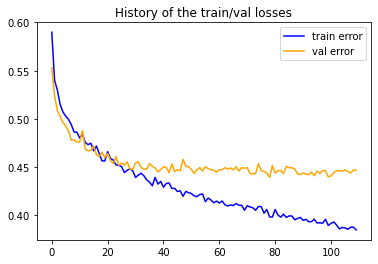

Saving the hyperparameters : 


In [100]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

In [ ]:
folder_test = "../dataset/train_test/good"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/average"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/bad"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/complete"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

### Onet

In [101]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.onet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False


model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False

# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False

# model.conv4.weight.requires_grad = False
# model.conv4.bias.requires_grad = False
# model.prelu4.weight.requires_grad = False

# model.dense5.weight.requires_grad = False
# model.dense5.bias.requires_grad = False
# model.prelu5.weight.requires_grad = False

model.dense6_2.weight.requires_grad = False
model.dense6_2.bias.requires_grad = False

model.dense6_3.weight.requires_grad = False
model.dense6_3.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()


network = "onet"
input_size = 48
num_epochs = 110

Initializing Datasets and Dataloaders...
Printing training images : 


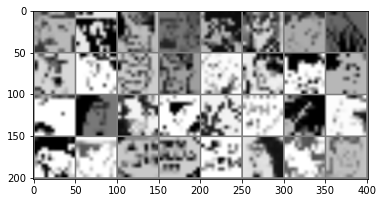

tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1])
Params to learn:
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4.weight
	 conv4.bias
	 prelu4.weight
	 dense5.weight
	 dense5.bias
	 prelu5.weight
	 dense6_1.weight
	 dense6_1.bias
Starting the training : 
Epoch 0/109
----------
train Loss: 0.5950 Acc: 0.7009
val Loss: 0.4912 Acc: 0.8167
Epoch 1/109
----------
train Loss: 0.4977 Acc: 0.8149
val Loss: 0.4665 Acc: 0.8434
Epoch 2/109
----------
train Loss: 0.4923 Acc: 0.8206
val Loss: 0.4603 Acc: 0.8505
Epoch 3/109
----------
train Loss: 0.4743 Acc: 0.8380
val Loss: 0.4385 Acc: 0.8754
Epoch 4/109
----------
train Loss: 0.4575 Acc: 0.8540
val Loss: 0.4510 Acc: 0.8630
Epoch 5/109
----------
train Loss: 0.4553 Acc: 0.8518
val Loss: 0.4399 Acc: 0.8648
Epoch 6/109
----------
train Loss: 0.4409 Acc: 0.8749
val Loss: 0.4362 Acc: 0.8719
Epoch 7/109
----------
train Loss: 0.4345 Acc: 0.8789
val Loss: 0.4376 Acc: 0.8808
Epoch 8/109
-

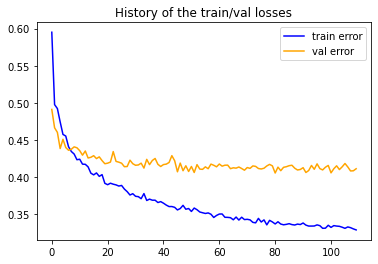

Saving the hyperparameters : 


In [102]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

In [132]:
folder_test = "../dataset/train_test/good"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/average"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/bad"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/complete"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

Testing on the ../dataset/train_test/good folder : 
 Precision, Recall, f-score


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


0.7908745247148289 0.6887417218543046 0.736283185840708
Testing on the ../dataset/train_test/average folder : 
 Precision, Recall, f-score


100%|██████████| 76/76 [00:24<00:00,  3.09it/s]


0.6882845188284519 0.5981818181818181 0.6400778210116731
Testing on the ../dataset/train_test/bad folder : 
 Precision, Recall, f-score


100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


0.6804979253112033 0.39518072289156625 0.5
Testing on the ../dataset/train_test/complete folder : 
 Precision, Recall, f-score


100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


0.6910229645093946 0.5648464163822525 0.6215962441314553


## Test different thresholds

In [122]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.95, 0.95, 0.95])

Running on device: cuda:0


In [123]:
mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_s2_v2/full_training_s2_v2-onet.pth", map_location=device))

<All keys matched successfully>

In [39]:
folder_test = "../dataset/train_test/good"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/average"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/bad"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

folder_test = "../dataset/train_test/complete"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

Testing on the ../dataset/train_test/good folder : 
 Precision, Recall, f-score


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


0.7908745247148289 0.6887417218543046 0.736283185840708
Testing on the ../dataset/train_test/average folder : 
 Precision, Recall, f-score


100%|██████████| 76/76 [00:24<00:00,  3.11it/s]


0.6882845188284519 0.5981818181818181 0.6400778210116731
Testing on the ../dataset/train_test/bad folder : 
 Precision, Recall, f-score


100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


0.6804979253112033 0.39518072289156625 0.5
Testing on the ../dataset/train_test/complete folder : 
 Precision, Recall, f-score


100%|██████████| 161/161 [00:53<00:00,  2.99it/s]


0.6910229645093946 0.5648464163822525 0.6215962441314553


## Extract neg samples 

In [79]:
network = "onet"
input_size = 48
num_epochs = 150

In [80]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_s2_v0/full_training_s2_v0-onet.pth", map_location=device))

Running on device: cuda:0


<All keys matched successfully>

In [131]:
folder_test = "../dataset/train_test/style2"
print("Testing on the %s folder : \n Precision, Recall, f-score"%(folder_test))
pred_mtcnn, groundtruth = testing(folder_test, folder_store, network, img_skip = [], get_fp = True)

Testing on the ../dataset/train_test/style2 folder : 
 Precision, Recall, f-score


100%|██████████| 51/51 [00:26<00:00,  1.89it/s]


0.8291571753986332 0.4899057873485868 0.6159052453468697


In [83]:
def framework(folder_img, folder_gt, resize, folder_store, threshold = 0.1, nb_max_copy = 5, crop_size = 20, pred = None) :
    
    print("Loading images from folder : ", folder_img)
    #folder="dcm_dataset.git/images/images"
    images, path_images = load_images_from_folder(folder_img)
    print("Check dataset length : ", len(images))

    # Load groundtruth :
    print("Loading groundtruth from folder : ", folder_gt)
    #folder="dcm_dataset.git\groundtruth"
    groundtruth, path_groundtruth = load_all_groundtruth(folder_gt, 5)
    print("Check groundtruth length : ", len(groundtruth))

    # Change size :
    print("resizing to width = ", resize)
    resize_img_and_gt(resize, images, groundtruth)
    
    # Extract faces
    print("Extracting faces, storing in : ", folder_store)
    get_set_faces(images, groundtruth, folder_store, threshold, nb_max_copy, crop_size, pred, nb_neg = 2)


In [84]:
folder_img="../dataset/train_test/style2/img_train"
folder_gt="../dataset/train_test/style2/gt_train"
folder_store="../dataset/faces/style2/v1"

framework(folder_img, folder_gt, 800, folder_store, threshold = 0.2, nb_max_copy = 2, crop_size = 12, pred = pred_mtcnn)  

Loading images from folder :  ../dataset/train_test/style2/img_train
Check dataset length :  51
Loading groundtruth from folder :  ../dataset/train_test/style2/gt_train
Check groundtruth length :  51
resizing to width =  800
Extracting faces, storing in :  ../dataset/faces/style2/v1


### Check accuracy on an already trained model

In [126]:
data_dir = "../dataset/faces/complete/fpv3"

In [127]:
data_transforms = get_transformation(48)
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


In [128]:
mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_comp_fp_v4/full_training_comp_fp_v4-onet.pth", map_location=device))

<All keys matched successfully>

In [129]:
def check_accuracy(dataloaders, model, network):
    num_samples = 0
    model.eval()
    running_corrects = 0
    
    for inputs, labels in dataloaders['val']:
        inputs = inputs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            if network == "onet" :
                outputs_box, output_landmark, aux_outputs = model(inputs)
                        
            else :
                outputs, aux_outputs = model(inputs)

            aux_outputs = aux_outputs.reshape(-1, num_classes)
            _, preds = torch.max(aux_outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
                
    epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)
    print("Accuracy : %s"%(epoch_acc)) 

In [130]:
check_accuracy(dataloaders_dict, mtcnn.onet, "onet")

Accuracy : tensor(0.8580, device='cuda:0', dtype=torch.float64)
